In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.signal import fftconvolve
from matplotlib.colors import LogNorm
from scipy import stats
import random
from scipy.interpolate import interp1d
from scipy.stats import poisson
from scipy.fft import fft, fftfreq
from pyunfold import iterative_unfold
from pyunfold.callbacks import Logger
from pyunfold.priors import jeffreys_prior, uniform_prior

In [78]:
nevents=100000
x0 = 1836.4 # M2
gamma0 = 8.2
x1 =  2047 # M1
gamma1 = 14.49
mu = 0
N_detectors = 20
sigma=np.random.uniform(5,7,N_detectors)
gaussian_par=[mu,sigma]
cauchy_par_test_0=[x0,gamma0]
cauchy_par_test_1=[x1,gamma1]

cauchy_par_0=[x0-10,gamma0+4]
cauchy_par_1=[x1+20,gamma1-1]

x_min=1200
x_max=2700
x_nbins=100
b_min=1200
b_max=2700
b_nbins=100
#binwidth di 15 eV
nevents_test_1=np.random.randint(nevents-np.sqrt(nevents),nevents+np.sqrt(nevents),N_detectors)
nevents_test_0=np.random.randint(nevents-np.sqrt(nevents),nevents+np.sqrt(nevents),N_detectors)
def bins_and_centers(nbins, low, high):
    bins = np.linspace(low, high, nbins + 1)
    bin_centers = (bins + (bins[1] - bins[0]) / 2)[:-1]
    return bins, bin_centers


def add_smearing(x, n):
    smear = np.random.normal(gaussian_par[0],gaussian_par[1][n])
    return x + smear


def stddev(x_test,x,N):
    std_dev = []
    for i in range(N):
        temp = []
        for j in range(len(x[i])):
            temp.append(np.sqrt(np.sum((x_test[j]-x[i,j])**2)/(N))) #(len(x[i])-1)*
        std_dev.append(temp)
    std_dev = np.array(std_dev, dtype=float)
    return std_dev


(1200.0, 2700.0)

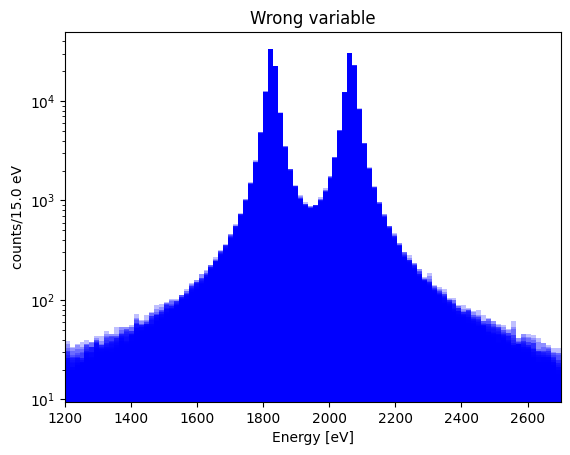

In [79]:
plt.figure(1)
xini_peak_0 = []
xini_peak_1 = []
for i in range(len(nevents_test_0)):
    xini_peak_0.append(stats.cauchy.rvs(cauchy_par_0[0], cauchy_par_0[1], nevents))
    xini_peak_1.append(stats.cauchy.rvs(cauchy_par_1[0], cauchy_par_1[1], nevents))
xini_peak_0 = np.array(xini_peak_0, dtype=object)
xini_peak_1 = np.array(xini_peak_1, dtype=object)
xini_peak = []
for i in range(len(nevents_test_0)):
    combined_row = np.concatenate((xini_peak_0[i], xini_peak_1[i]))
    xini_peak.append(combined_row)
xini_peak = np.array(xini_peak, dtype=object)
for i in range(len(nevents_test_0)):
    plt.hist(xini_peak[i], x_nbins, range=[x_min,x_max],histtype="stepfilled", color="blue", alpha=0.25)
plt.title("Wrong variable")
plt.ylabel("counts/{} eV".format((x_max-x_min)/x_nbins))
plt.xlabel("Energy [eV]")
plt.yscale("log")
plt.savefig("/home/sara/Downloads/wrongvariable.png")
plt.xlim(x_min,x_max)

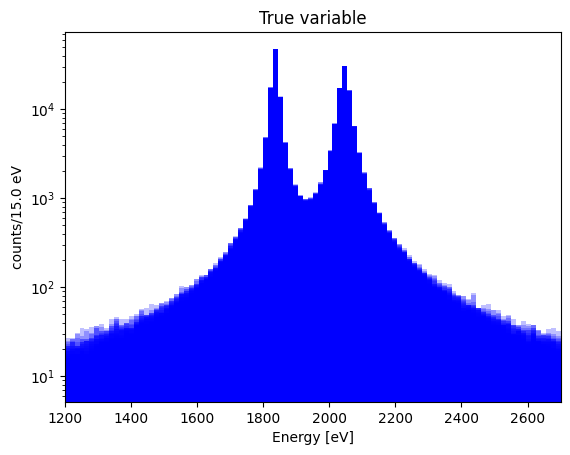

In [80]:
plt.figure(2)
xini_peak_test_0 = []
xini_peak_test_1 = []
for i in range(len(nevents_test_0)):
    xini_peak_test_0.append(stats.cauchy.rvs(cauchy_par_test_0[0], cauchy_par_test_0[1], nevents_test_0[i]))
    xini_peak_test_1.append(stats.cauchy.rvs(cauchy_par_test_1[0], cauchy_par_test_1[1], nevents_test_1[i]))
xini_peak_test_0 = np.array(xini_peak_test_0, dtype=object)
xini_peak_test_1 = np.array(xini_peak_test_1, dtype=object)
xini_peak_test = []
for i in range(len(nevents_test_0)):
    combined_row = np.concatenate((xini_peak_test_0[i], xini_peak_test_1[i]))
    xini_peak_test.append(combined_row)
xini_peak_test = np.array(xini_peak_test, dtype=object)
for i in range(len(nevents_test_0)):
    plt.hist(xini_peak_test[i], x_nbins, range=[x_min,x_max],histtype="stepfilled", color="blue", alpha=0.25)
plt.title("True variable")
plt.ylabel("counts/{} eV".format((x_max-x_min)/x_nbins))
plt.xlabel("Energy [eV]")
plt.yscale("log")
plt.xlim(x_min,x_max)
plt.savefig("/home/sara/Downloads/truevariable.png")


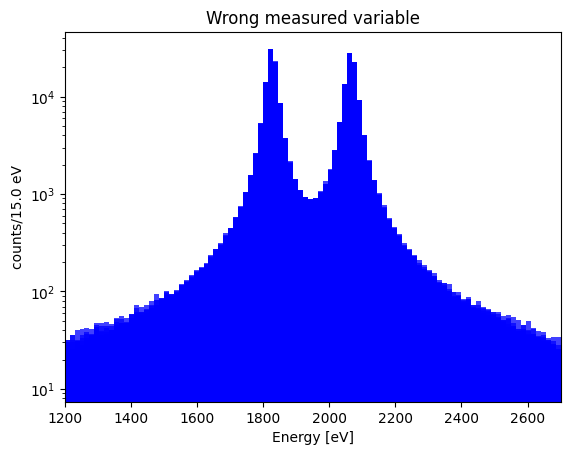

In [81]:

plt.figure(3)
b_ini_gen = []
for i in range(len(nevents_test_0)):
    b_ini_gen.append([add_smearing(x, i) for x in xini_peak[i]])

b_ini_gen = np.array(b_ini_gen, dtype=object)
for i in range(len(nevents_test_0)):
    plt.hist(b_ini_gen[i], x_nbins, range=[x_min,x_max],histtype="stepfilled", color="blue", alpha=0.75)
plt.title("Wrong measured variable")
plt.ylabel("counts/{} eV".format((x_max-x_min)/x_nbins))
plt.xlabel("Energy [eV]")
plt.yscale("log")
plt.xlim(x_min,x_max)

plt.savefig("/home/sara/Downloads/wrongmeasuredvariable.png")


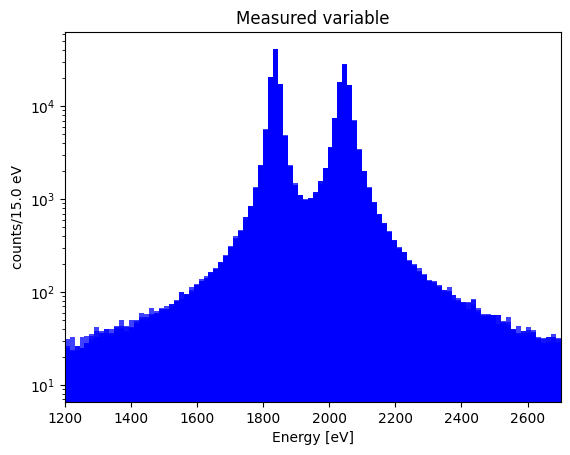

In [82]:

plt.figure(4)
b_test_gen = []
for i in range(len(nevents_test_0)):
    b_test_gen.append([add_smearing(x, i) for x in xini_peak_test[i]])

b_test_gen = np.array(b_test_gen, dtype=object)
for i in range(len(nevents_test_0)):
    plt.hist(b_test_gen[i], x_nbins, range=[x_min,x_max],histtype="stepfilled", color="blue", alpha=0.75)
plt.title("Measured variable")
plt.ylabel("counts/{} eV".format((x_max-x_min)/x_nbins))
plt.xlabel("Energy [eV]")
plt.yscale("log")
plt.xlim(x_min,x_max)
plt.savefig("/home/sara/Downloads/measuredvariable.png")


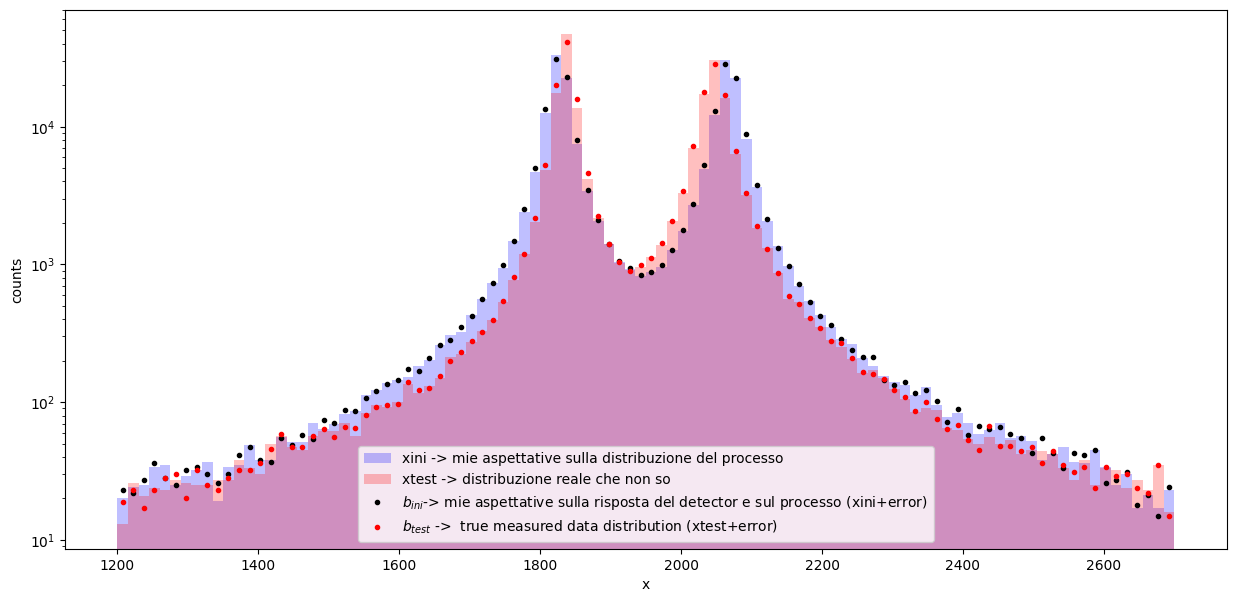

In [83]:

bins_x, bin_centers_x = bins_and_centers(x_nbins, x_min, x_max)
bins_b, bin_centers_b = bins_and_centers(b_nbins, b_min, b_max)
x_test_gen = xini_peak_test
x_ini_gen = xini_peak
x_ini = []
x_test = []
b_ini = []
b_test = []
scale_factor = []
for i in range(len(nevents_test_0)):
    x_ini.append(np.histogram(x_ini_gen[i], bins_x)[0])
    x_test.append(np.histogram(x_test_gen[i], bins_x)[0])
    scale_factor.append(len(x_test_gen[i])/len(x_ini_gen[i]))
    b_ini.append(np.histogram(b_ini_gen[i], bins_b)[0])
    b_test.append(np.histogram(b_test_gen[i], bins_b)[0])

b_ini = np.array(b_ini, dtype=float)
x_ini = np.array(x_ini, dtype=float)
x_test = np.array(x_test, dtype=float)
b_test = np.array(b_test, dtype=float)
b_test_err = []
x_test_err = []
b_ini_err = []

for i in range(len(nevents_test_0)):
    b_test_err.append(np.sqrt(b_test[i].astype("float")))
    x_test_err.append(np.sqrt(x_test[i].astype("float")))
    b_ini_err.append(np.sqrt(b_ini[i].astype("float")))

b_test_err = np.array(b_test_err, dtype=float)
x_test_err = np.array(x_test_err, dtype=float)
b_ini_err = np.array(b_ini_err, dtype=float)


plt.figure(figsize=(15, 7))

plt.hist(x_ini_gen[0], density=False, bins=x_nbins, histtype="stepfilled", color="blue", 
         label="xini -> mie aspettative sulla distribuzione del processo", alpha=0.25, weights=scale_factor[0]*np.ones(len(x_ini_gen[0])), range=[x_min, x_max])
plt.hist(x_test_gen[0], density=False, bins=x_nbins, histtype="stepfilled", color="red", label="xtest -> distribuzione reale che non so", alpha=0.25, range=[x_min, x_max])

plt.plot(bin_centers_b, b_ini[0]*scale_factor[0], ".", color="black", label="$b_{ini}$-> mie aspettative sulla risposta del detector e sul processo (xini+error)")
plt.plot(bin_centers_b, b_test[0], ".", color="red", label="$b_{test}$ ->  true measured data distribution (xtest+error)")

plt.xlabel("x")
plt.ylabel("counts")
plt.yscale("log")
plt.legend()


## Unfolding

In [84]:
response_hist = []
response_hist_err = []
efficiencies = []
efficiencies_err = []

for i in range(N_detectors):
    efficiencies.append(np.ones_like(b_test[i], dtype=float))
    efficiencies_err.append(np.full_like(efficiencies[i], 0.1, dtype=float))

efficiencies = np.array(efficiencies, dtype=float)
efficiencies_err = np.array(efficiencies_err, dtype=float)
column_sums = []
normalization_factor = []
response = []
response_err = []
unfolded_results = []
for i in range(N_detectors):
    response_hist.append(np.histogram2d(b_ini_gen[i], x_ini_gen[i], bins=[bins_b,bins_x])[0])
    response_hist_err.append(np.sqrt(response_hist[i]))
    column_sums.append(response_hist[i].sum(axis=0))
    normalization_factor.append(efficiencies[i] / column_sums[i])
    response.append(response_hist[i] * normalization_factor[i])
    response_err.append(response_hist_err[i] * normalization_factor[i])

    #plt.figure(7+i)
    #plt.imshow(response_hist[i], norm=LogNorm(vmin=1, vmax=1e4), cmap="YlGnBu", extent=[bins_b[0], bins_b[-1],bins_b[-1],bins_b[0]])
#plt.colorbar()
#plt.xlabel('Cause bins')
#plt.ylabel('Effect bins')
#plt.title('Normalizes response matrix')
response = np.array(response, dtype=float)
response_err = np.array(response_err, dtype=float)
x = []
err = []
err_plus_sys = []
for i in range(len(nevents_test_0)):
    unfolded_results = iterative_unfold(data=b_test[i],
                                        data_err=b_test_err[i],
                                        response=response[i],
                                        response_err=response_err[i],
                                        efficiencies=efficiencies[i],
                                        efficiencies_err=efficiencies_err[i],
                                        callbacks=[Logger()])
    x.append(unfolded_results['unfolded'])
    X = unfolded_results['stat_err']
    X1 = unfolded_results['sys_err']
    err.append(np.sqrt(X**2))
    err_plus_sys.append(np.sqrt(X**2+X1**2))

Iteration 1: ts = 0.3600, ts_stopping = 0.01
Iteration 2: ts = 0.0203, ts_stopping = 0.01
Iteration 3: ts = 0.0101, ts_stopping = 0.01
Iteration 4: ts = 0.0059, ts_stopping = 0.01
Iteration 1: ts = 0.3584, ts_stopping = 0.01
Iteration 2: ts = 0.0196, ts_stopping = 0.01
Iteration 3: ts = 0.0105, ts_stopping = 0.01
Iteration 4: ts = 0.0065, ts_stopping = 0.01
Iteration 1: ts = 0.3588, ts_stopping = 0.01
Iteration 2: ts = 0.0200, ts_stopping = 0.01
Iteration 3: ts = 0.0105, ts_stopping = 0.01
Iteration 4: ts = 0.0065, ts_stopping = 0.01
Iteration 1: ts = 0.3595, ts_stopping = 0.01
Iteration 2: ts = 0.0201, ts_stopping = 0.01
Iteration 3: ts = 0.0104, ts_stopping = 0.01
Iteration 4: ts = 0.0064, ts_stopping = 0.01
Iteration 1: ts = 0.3589, ts_stopping = 0.01
Iteration 2: ts = 0.0190, ts_stopping = 0.01
Iteration 3: ts = 0.0102, ts_stopping = 0.01
Iteration 4: ts = 0.0065, ts_stopping = 0.01
Iteration 1: ts = 0.3592, ts_stopping = 0.01
Iteration 2: ts = 0.0200, ts_stopping = 0.01
Iteration 

## Istogramma unico finale unendo più detectors

[  1.16374937   1.2012766    1.0884158    1.26482399   1.35646916
   1.29198624   1.38485492   1.23135248   1.44100253   1.52368642
   1.51000924   1.5820458    1.67839489   1.74057191   1.77485229
   1.88459997   1.96057945   2.0729687    2.14319783   2.19316222
   2.29842679   2.45818344   2.66698877   2.81036575   2.94541645
   3.12550187   3.41885859   3.75201101   3.96156583   4.33035606
   4.73186581   5.39888341   6.10930266   7.31105031   8.60495623
  10.37059513  13.51071264  18.85768155  29.00276941  53.64411225
 136.97335798 457.11354831 582.11030236 432.59452798 124.98922564
  50.79860766  31.00533245  23.66345472  20.88683552  21.39273172
  24.65393481  31.63095302  46.21883162  79.68858613 178.52638241
 393.22100669 473.39505959 343.93980179 150.18944816  73.34517824
  43.39504552  28.04693581  19.93289651  15.08396734  11.97442935
  10.02366727   8.36964906   7.06382181   6.44728124   5.54852924
   4.94029737   4.67023867   4.21894656   3.81385765   3.49727689
   3.31166

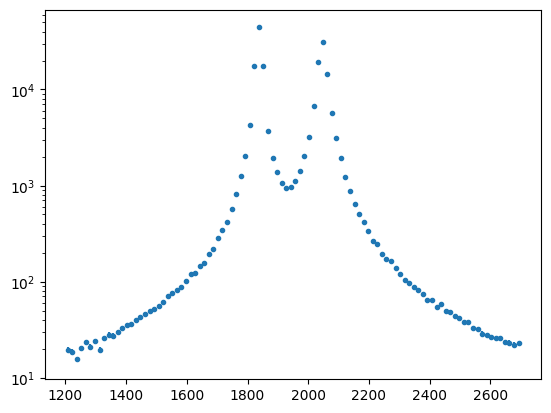

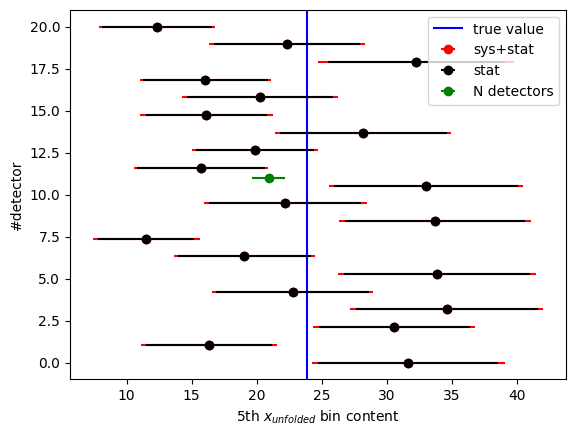

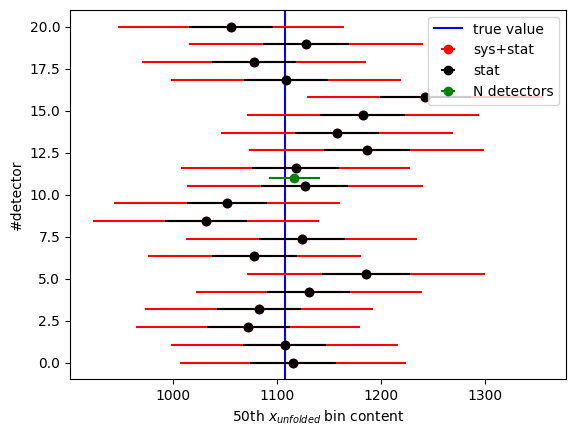

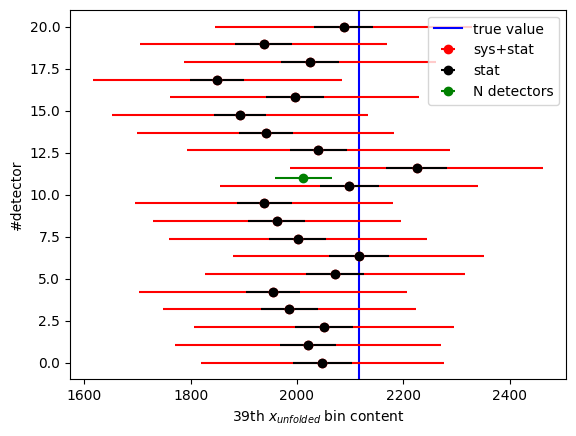

In [85]:
x = np.array(x, dtype=float)
err = np.array(err, dtype=float)
err_plus_sys = np.array(err_plus_sys, dtype=float)
N_d = np.linspace(0, N_detectors, N_detectors)

b_final_test = np.mean(b_test, axis=0)
x_final_test = np.mean(x_test, axis=0)

plt.figure(2)
weights = 1 / (err_plus_sys ** 2)
denominator = np.sum(weights, axis=0)
numerator = np.sum((x * weights), axis=0)
x_final = numerator / denominator
error_tot = np.sqrt(1./denominator)
print(error_tot)

plt.errorbar(bin_centers_x,x_final, marker=".", yerr=error_tot, linestyle="")
plt.yscale("log")
plt.figure(66)
plt.axvline(x=x_final_test[5], color='b', label='true value')
plt.errorbar(x[:,5],N_d, xerr=err_plus_sys[:,5], linestyle="", marker="o", color="red", label="sys+stat")
plt.errorbar(x[:,5],N_d, xerr=err[:,5], linestyle="", marker="o", color="black", label="stat")
plt.errorbar(x_final[5],11, xerr=error_tot[5], linestyle="", marker="o", color="green", label="N detectors")

plt.legend()
plt.xlabel("5th $x_{unfolded}$ bin content")
plt.ylabel("#detector")
plt.savefig("/home/sara/Downloads/ppyunfold_5th_bin.png")
plt.figure(67)
plt.axvline(x=x_final_test[50], color='b', label='true value')
plt.errorbar(x[:,50],N_d, xerr=err_plus_sys[:,50], linestyle="", marker="o", color="red", label="sys+stat")
plt.errorbar(x[:,50],N_d, xerr=err[:,50], linestyle="", marker="o", color="black", label="stat")
plt.errorbar(x_final[50],11, xerr=error_tot[50], linestyle="", marker="o", color="green", label="N detectors")

plt.xlabel("50th $x_{unfolded}$ bin content")
plt.ylabel("#detector")
plt.legend()
plt.savefig("/home/sara/Downloads/ppyunfold_50th_bin.png")
plt.figure(68)
d=39
plt.axvline(x=x_final_test[d], color='b', label='true value')
plt.errorbar(x[:,d],N_d, xerr=err_plus_sys[:,d], linestyle="", marker="o", color="red", label="sys+stat")
plt.errorbar(x[:,d],N_d, xerr=err[:,d], linestyle="", marker="o", color="black", label="stat")
plt.errorbar(x_final[d],11, xerr=error_tot[d], linestyle="", marker="o", color="green", label="N detectors")
plt.xlabel("39th $x_{unfolded}$ bin content")
plt.ylabel("#detector")
plt.legend() 
plt.savefig("/home/sara/Downloads/ppyunfold_39th_bin.png")

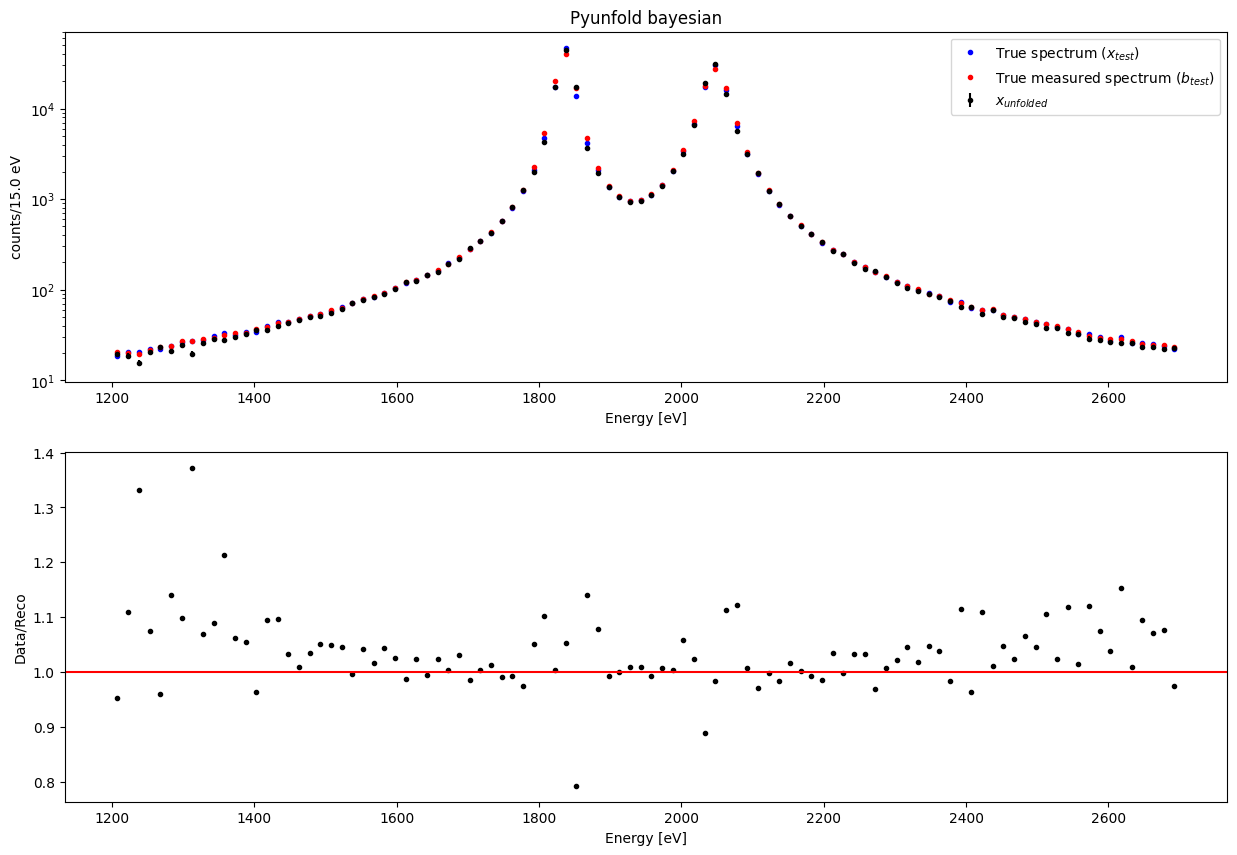

In [86]:

plt.subplots(2 , 1, figsize=(15, 10))
plt.subplot(2,1,1)
plt.plot(bin_centers_x, x_final_test, ".", color="blue", label="True spectrum ($x_{test}$)")
plt.plot(bin_centers_b, b_final_test, ".", color="red", label="True measured spectrum ($b_{test}$)")
plt.title("Pyunfold bayesian")

plt.errorbar(bin_centers_x, x_final, yerr=error_tot, label="$x_{unfolded}$" , marker='.', linestyle="", color="black")
plt.xlabel("Energy [eV]")
plt.ylabel("counts/{} eV".format((x_max-x_min)/x_nbins))
plt.legend()
plt.yscale("log")
plt.subplot(2,1,2)
plt.plot(bin_centers_x,(x_final_test/x_final), marker='.', linestyle="", color="black")
plt.xlabel("Energy [eV]")
plt.ylabel("Data/Reco")
plt.axhline(y=1, color="red")
plt.savefig("/home/sara/Downloads/ppyunfold_20detector.png")

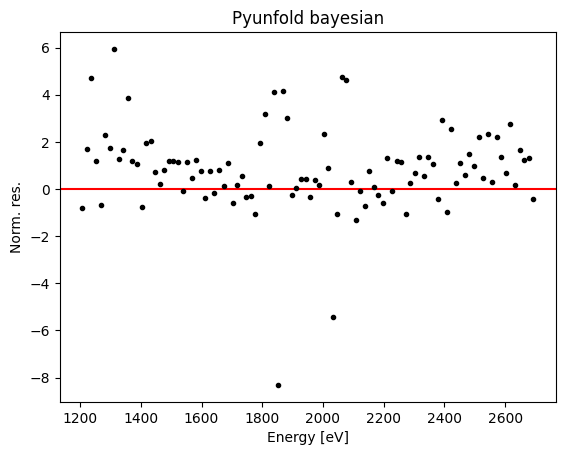

In [88]:
plt.figure(25)
plt.title("Pyunfold bayesian")
plt.xlabel("Energy [eV]")
plt.errorbar(bin_centers_x,(x_final_test-x_final)/error_tot, marker='.', linestyle="", color="black")
plt.xlabel("Energy [eV]")
plt.ylabel("Norm. res.")
plt.axhline(y=0, color="red")
plt.savefig("/home/sara/Downloads/ppyunfold_20detector_bias.png")
plt.show()

## Stima del bias

In [31]:
x = []
err = []
unfolded_results_b = []
err_plus_sys = []
efficiencies = []
efficiencies_err = []

for i in range(N_detectors):
    efficiencies.append(np.ones_like(b_ini[i], dtype=float))
    efficiencies_err.append(np.full_like(efficiencies[i], 0.1, dtype=float))
efficiencies = np.array(efficiencies, dtype=float)
efficiencies_err = np.array(efficiencies_err, dtype=float)
response = []
response_err = []
unfolded_results = []
for i in range(N_detectors):
    response_hist.append(np.histogram2d(b_ini_gen[i], x_ini_gen[i], bins=[bins_b,bins_x])[0])
    response_hist_err.append(np.sqrt(response_hist[i]))
    column_sums.append(response_hist[i].sum(axis=0))
    normalization_factor.append(efficiencies[i] / column_sums[i])
    response.append(response_hist[i] * normalization_factor[i])
    response_err.append(response_hist_err[i] * normalization_factor[i])

response = np.array(response, dtype=float)
response_err = np.array(response_err, dtype=float)

for i in range(len(nevents_test_0)):
    unfolded_results_b = iterative_unfold(data=b_ini[i],
                                        data_err=b_ini_err[i],
                                        response=response[i],
                                        response_err=response_err[i],
                                        efficiencies=efficiencies[i],
                                        efficiencies_err=efficiencies_err[i],
                                        callbacks=[Logger()])
    x.append(unfolded_results_b['unfolded'])
    X_b = unfolded_results_b['stat_err']
    X1_b = unfolded_results_b['sys_err']
    err.append(np.sqrt(X_b**2))
    err_plus_sys.append(np.sqrt(X_b**2+X1_b**2))

Iteration 1: ts = 0.3433, ts_stopping = 0.01
Iteration 2: ts = 0.0147, ts_stopping = 0.01
Iteration 3: ts = 0.0054, ts_stopping = 0.01
Iteration 1: ts = 0.3430, ts_stopping = 0.01
Iteration 2: ts = 0.0149, ts_stopping = 0.01
Iteration 3: ts = 0.0054, ts_stopping = 0.01
Iteration 1: ts = 0.3445, ts_stopping = 0.01
Iteration 2: ts = 0.0141, ts_stopping = 0.01
Iteration 3: ts = 0.0051, ts_stopping = 0.01
Iteration 1: ts = 0.3448, ts_stopping = 0.01
Iteration 2: ts = 0.0156, ts_stopping = 0.01
Iteration 3: ts = 0.0056, ts_stopping = 0.01
Iteration 1: ts = 0.3435, ts_stopping = 0.01
Iteration 2: ts = 0.0141, ts_stopping = 0.01
Iteration 3: ts = 0.0051, ts_stopping = 0.01
Iteration 1: ts = 0.3437, ts_stopping = 0.01
Iteration 2: ts = 0.0164, ts_stopping = 0.01
Iteration 3: ts = 0.0058, ts_stopping = 0.01
Iteration 1: ts = 0.3438, ts_stopping = 0.01
Iteration 2: ts = 0.0163, ts_stopping = 0.01
Iteration 3: ts = 0.0059, ts_stopping = 0.01
Iteration 1: ts = 0.3437, ts_stopping = 0.01
Iteration 

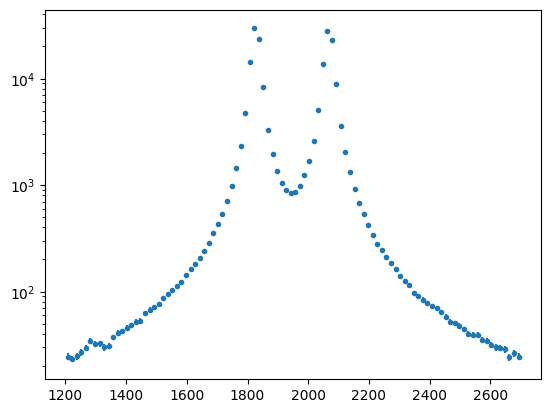

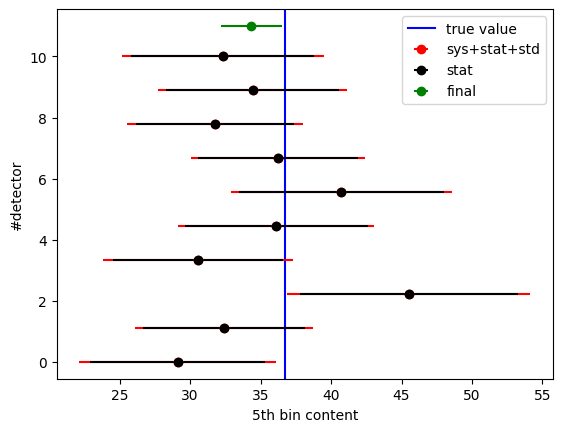

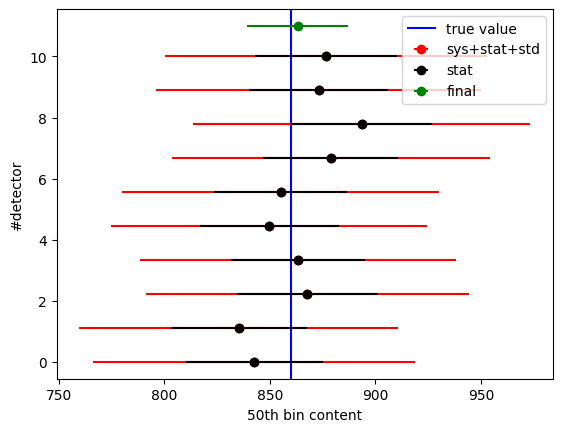

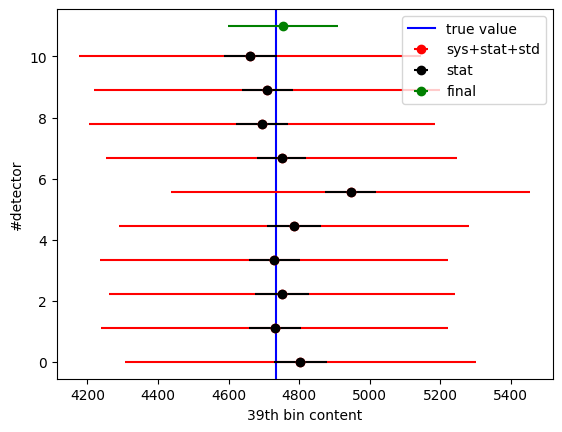

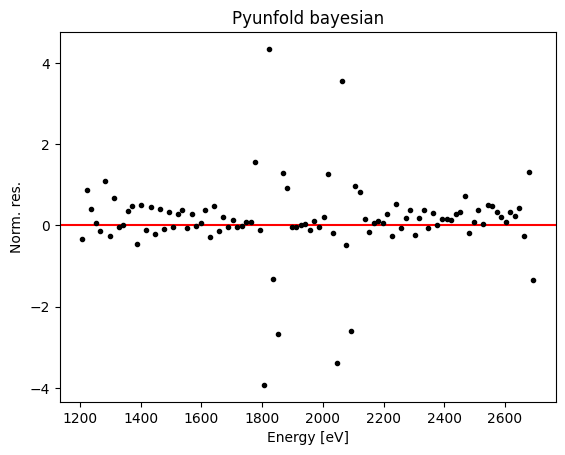

In [32]:
x = np.array(x, dtype=float)
err = np.array(err, dtype=float)
err_plus_sys = np.array(err_plus_sys, dtype=float)
N_d = np.linspace(0, N_detectors, N_detectors)

x_final_test = np.mean(x_ini, axis=0)
std_dev = stddev(x_final_test, x, N_detectors)
err_plus_sys = np.sqrt(err_plus_sys**2 + std_dev**2)


plt.figure(2)
weights = 1 / (err_plus_sys ** 2)
denominator = np.sum(weights, axis=0)
numerator = np.sum((x / (err_plus_sys ** 2)), axis=0)
x_final = numerator / denominator
error_tot = np.sqrt(1./np.sum(1./err_plus_sys**2, axis=0))


plt.errorbar(bin_centers_x,x_final, marker=".", yerr=error_tot, linestyle="")
plt.yscale("log")
plt.figure(66)
plt.axvline(x=x_final_test[5], color='b', label='true value')
plt.errorbar(x[:,5],N_d, xerr=err_plus_sys[:,5], linestyle="", marker="o", color="red", label="sys+stat+std")
plt.errorbar(x[:,5],N_d, xerr=err[:,5], linestyle="", marker="o", color="black", label="stat")
plt.errorbar(x_final[5],11, xerr=error_tot[5], linestyle="", marker="o", color="green", label="final")

plt.legend()
plt.xlabel("5th bin content")
plt.ylabel("#detector")

plt.figure(67)
plt.axvline(x=x_final_test[50], color='b', label='true value')
plt.errorbar(x[:,50],N_d, xerr=err_plus_sys[:,50], linestyle="", marker="o", color="red", label="sys+stat+std")
plt.errorbar(x[:,50],N_d, xerr=err[:,50], linestyle="", marker="o", color="black", label="stat")
plt.errorbar(x_final[50],11, xerr=error_tot[50], linestyle="", marker="o", color="green", label="final")

plt.xlabel("50th bin content")
plt.ylabel("#detector")
plt.legend()

plt.figure(68)
d=39
plt.axvline(x=x_final_test[d], color='b', label='true value')
plt.errorbar(x[:,d],N_d, xerr=err_plus_sys[:,d], linestyle="", marker="o", color="red", label="sys+stat+std")
plt.errorbar(x[:,d],N_d, xerr=err[:,d], linestyle="", marker="o", color="black", label="stat")
plt.errorbar(x_final[d],11, xerr=error_tot[d], linestyle="", marker="o", color="green", label="final")
plt.xlabel("39th bin content")
plt.ylabel("#detector")
plt.legend() 

plt.figure(25)
plt.title("Pyunfold bayesian")
plt.xlabel("Energy [eV]")
plt.errorbar(bin_centers_x,(x_final_test-x_final)/error_tot, marker='.', linestyle="", color="black")
plt.xlabel("Energy [eV]")
plt.ylabel("Norm. res.")
plt.axhline(y=0, color="red")
